# Appendix B. Quaternion Kinematics and Differential Equations
** Contributors: Mark E. Petersen **

### Table Of Contents
1. [Introduction](#Introduction)
1. [Motivating Example](#Motivating-Example)
    1. [Group Representation Class](#Group-Representation-Class)
    1. [Visualize Class](#Visualize-Class)
    1. [Kinematics](#Kinematics)
1. [Naive Integration Methods](#Naive-Integration-Methods)
    1. [Euler's Method](#Euler's-Method)
    1. [Runge-Kutta 4 (RK4) ](#Runge-Kutta-4-%28RK4%29)
1. [Integrating on the Manifold](#Integrating-on-the-Manifold)
    1. [Digital Implementation](#Digital-Implementation)

## Introduction

This appendix continues the discussion of using the unit quaternion to represent attitude which was introduced in [Appendix A](A-Attitude-Representations.ipynb). In this notebook, we will derive and discuss the unit quaternion kinematics to describe and object's rotation. Using these kinematics, we can solve differential equation to express an object's rotation as a function of time. The attitude kinematics can be propagated on and off the manifold using different techniques such as Euler Integration, Runge-Kutta (RK4) Integration, and integrating directly on the manifold. 

This appendix follows the outline shown in [Solving Differential Equations](/notebooks/Unit-1-SO2/1.3-Solving-Differential-Equations.ipynb) and it will extend the motivating example to SO(3) using the unit quaternion lie group. 

## Motivating Example
We will consider a rotating plane that doesn't translate. The plane's angular velocity is given by the column vector $\omega = \left[\dot{\phi},\dot{\theta},\dot{\psi} \right]^T$, which is being measured at a sampling rate of $Ts = 0.01$ seconds. 

Let's first generate samples from the gyro on our spinning plane. We assume that the plane starts with some initial velocity that slowly decays over time.

<IPython.core.display.Javascript object>


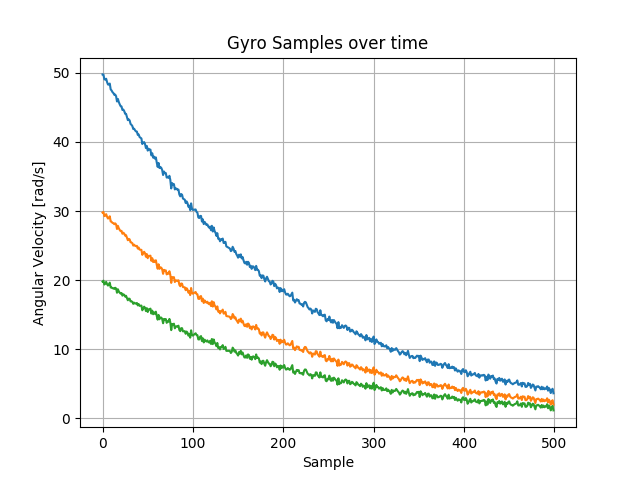

In [1]:
%matplotlib notebook
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

def generate_gyro_samples(w0=np.array([[50],[30],[20]]), Ts=0.01, secs=5, alpha=0.5, sigma=0.25):
    
    # Number of samples
    N = np.int(secs/Ts)

    # Sample time vector
    n=np.arange(N)

    # Generate the slowly-decaying signal
    w=np.multiply(w0,np.exp(-alpha*n*Ts))

    # Make some noise!
    eta = sigma*np.random.randn(N)

    d = {'w':w+eta, 'Ts':Ts, 'secs':secs, 'alpha':alpha, 'sigma':sigma}

    return d

samples = generate_gyro_samples()
w = samples['w']
fig = plt.figure()
plt.plot(w.transpose())
plt.title('Gyro Samples over time')
plt.grid();plt.xlabel('Sample'); plt.ylabel('Angular Velocity [rad/s]')
plt.show()

### Group Representation Class
We will use the unit quaternion to represent the attitude of the plane in $S^3$. To do this, the following class is used whose methods were constructed based on the dicussuion in [Appendix-A](A-Attitude-Representations.ipynb)

In [2]:
import numpy as np 


class Quaternion:

    # Constructs the quaternion q = [w,x,y,z] where
    # w is the scalar and x,y,z form the vector.
    def __init__(self, *args):

        self._w, self._x, self._y, self._z = 1,0,0,0

        if len(args) == 0: # init identity quaternion
            self.init_quaternion(1,0,0,0)
        elif len(args) == 1: # init quaternion from rotation matrix
            self.r_to_q(args[0])
        elif len(args) == 2: # init quaternion from axel angel
            self.aa_to_q(args[0],args[1]) 
        elif len(args) == 3: # init quaternion from euler angles 
            self.euler_to_q(args[0],args[1],args[2])
        elif len(args) == 4: # init quaternion from scalar and vector
            self.init_quaternion(args[0],args[1],args[2],args[3])
        else:
            print('Input argument not understood. Using default')
            self.init_quaternion([1,0,0,0])



    # Basic quaternion constructor
    def init_quaternion(self, w, x, y, z):
        self._w = w     
        self._x = x     
        self._y = y     
        self._z = z  



    # Converts the rotation matrix to quaternion. 
    def r_to_q(self, R = np.identity(3)):
        self._w = 0.5*np.sqrt(1+np.float(R.trace()))
        self._x = 0.5*np.sqrt(1+R[0,0]-R[1,1]-R[2,2])
        self._y = 0.5*np.sqrt(1-R[0,0]+R[1,1]-R[2,2])
        self._z = 0.5*np.sqrt(1-R[0,0]-R[1,1]+R[2,2])



    # Converts quaternion to rotation matrix
    def q_to_r(self):

        r11 = self._w**2+self._x**2-self._y**2-self._z**2
        r12 = 2*(self._x*self._y + self._w*self._z)
        r13 = 2*(self._x*self._z - self._w*self._y)

        r21 = 2*(self._x*self._y - self._w*self._z)
        r22 = self._w**2-self._x**2+self._y**2-self._z**2
        r23 = 2*(self._y*self._z + self._w*self._x)

        r31 = 2*(self._x*self._z + self._w*self._y)
        r32 = 2*(self._y*self._z - self._w*self._x)
        r33 = self._w**2-self._x**2-self._y**2+self._z**2

        R = np.matrix([[r11,r12,r13], \
                      [r21,r22,r23], \
                      [r31,r32,r33]])

        return R



    # Converts angle axis to quaternion.
    # - theta is the angle of rotation in radians
    # - n is the axes about rotation 
    def aa_to_q(self, theta=0, n=np.array([0,0,0])):
        self._w = np.cos(theta/2)
        self._x = np.sin(theta/2)*n[0]
        self._y = np.sin(theta/2)*n[1]
        self._z = np.sin(theta/2)*n[2]



    # Converts quaternion to angle axis
    def q_to_aa(self):

        theta = 2*np.arcsin(np.sqrt(self._x**2+self._y**2+self._z**2))

        # There is no rotation, return identity element ?????
        if np.round(theta,4) == 0:
            theta = 0
            n1,n2,n3 = 0,0,0
        # There is rotation, compute vector elements
        else:
            n1 = self._x/np.sin(theta/2)
            n2 = self._y/np.sin(theta/2)
            n3 = self._z/np.sin(theta/2)

        return theta, np.array([n1,n2,n3])



    # Converts 321 sequence of euler angles to quaternion
    def euler_to_q(self, phi=0, theta=0, psi=0):
        c_psi,c_th,c_phi,s_psi,s_th,s_phi = np.cos(psi/2),np.cos(theta/2),np.cos(phi/2),np.sin(psi/2),np.sin(theta/2),np.sin(phi/2)
        self._w = c_psi*c_th*c_phi + s_psi*s_th*s_phi
        self._x = c_psi*c_th*s_phi - s_psi*s_th*c_phi
        self._y = c_psi*s_th*c_phi + s_psi*c_th*s_phi
        self._z = s_psi*c_th*c_phi - c_psi*s_th*s_phi



    # Returns the 321 sequence of euler angels
    def q_to_euler(self):
        theta = np.arcsin(2*(self._w*self._y-self._z*self._x))
        if (np.round(np.cos(theta),4) != 0):
            phi = np.arctan2(self._x+self._z,self._w-self._y) + np.arctan2(self._x-self._z,self._w+self._y)
            psi = np.arctan2(self._x+self._z,self._w-self._y) - np.arctan2(self._x-self._z,self._w+self._y)
        else:
            psi = 0
            if np.round(theta,4) == np.round(np.pi/2,4):
                phi = np.arctan2(self._x-self._z,self._w-self._y)
            else:
                phi = np.arctan2(self._x+self._z,self._w+self._y)
        return phi,theta,psi



    # Sets the quaternion to another quaternion
    def equal(self,q):
        self._w, self._x, self._y, self._z = q._w, q._x, q._y, q._z



    # Returns a copy of itself
    def copy(self):
        q = Quaternion()
        q.equal(self)
        return q



    # Returns the identity group element of the quaternion
    @staticmethod
    def identity():
        return Quaternion(1,0,0,0)



    # Overrides the addition operation
    def __add__(self,other):
        if other.__class__.__name__ == self.__class__.__name__:
            q = Quaternion(self._w+other._w, self._x+other._x, self._y+other._y, self._z+other._z)
        else:
            print("Only can do addition with type: "+self.__class__.__name__)
            q = Quaternion()
        return q



    # Implements quaternion division by a scalar
    def __div__(self,other):
        if np.isscalar(other):
            return self.scalar_mult(self,1.0/other)
        else:
            print("Only can do division with scalar")



    # Overrides the multiplication operation
    def __mul__(self,other):
        if other.__class__.__name__ == self.__class__.__name__:
            return self.quaternion_mult(self, other)
        elif isinstance(other,np.ndarray):
            return self.vector_rot(self,other)
        elif np.isscalar(other):
            return self.scalar_mult(self,other)
        else:
            print("Multiplication with type: "+ type(other).__name__ +" not implemented.")


        

    # Implements quaternion multiplication by a scalar
    @staticmethod
    def scalar_mult(q,s):
        return Quaternion(q._w*s,q._x*s,q._y*s,q._z*s)



    # Multiplies two quaternions together q1*q2
    @staticmethod
    def quaternion_mult(q2,q1):
        # q2.p()
        n_prime = q2.mat()
        n = np.matrix([[q1._x],[q1._y],[q1._z],[q1._w]])
        n_dprime = n_prime*n
        return Quaternion(n_dprime[3,0],n_dprime[0,0],n_dprime[1,0],n_dprime[2,0])



    # Rotates a vector by the quaternion
    @staticmethod
    def vector_rot(q,v):
        V = Quaternion(0,v[0,0],v[1,0],v[2,0]) # convert vector to quaternion
        V_prime = q*V*q.inv()
        return np.array([[V_prime._x],[V_prime._y],[V_prime._z]])



    # Converts the quaternion into matrix representation
    def mat(self):
        return np.matrix([[ self._w,  self._z, -self._y, self._x],
                          [-self._z,  self._w,  self._x, self._y],
                          [ self._y, -self._x,  self._w, self._z],
                          [-self._x, -self._y, -self._z, self._w]])



    # Returns the inverse of the quaternion
    def inv(self):
        return Quaternion(self._w, -self._x, -self._y, -self._z)



    # Returns the vector component of the quaternion
    def n(self):
        return np.array([[self._x],[self._y],[self._z]])



    # Transformation from algebra to group
    # - delta: 3d vector representing the axis-angle rotation
    #   ex: delta = np.array([[wx],[wy],[wz]])
    @staticmethod
    def from_algebra(delta):
        delta_norm = np.linalg.norm(delta)

        if (delta_norm > 1e-10):
            w = np.cos(delta_norm/2)
            n = np.sin(delta_norm/2)*delta/delta_norm
        else:
            w = 1
            n = delta/2
        return Quaternion(w,n[0,0],n[1,0],n[2,0])



    # Transformation from group to algebra
    # - delta: 3d vector representing the axis-angle rotation
    #   ex: delta = np.array([[wx],[wy],[wz]])
    def to_algebra(self):
        n_norm = np.linalg.norm(self.n())

        if (n_norm > 1e-10):
            delta = 2*np.arctan2(n_norm,self._w)*self.n()/n_norm
        else:
            delta = np.sign(self._w)*self.n()
        return delta

        

    # Normalize the quaternion so that
    # sqrt(w**2 + x**2 + y**2 + z**2) = 1
    def normalize(self):
        n = np.array([self._w, self._x, self._y, self._z])
        n = n/np.linalg.norm(n)
        self._w, self._x, self._y, self._z = n[0],n[1],n[2],n[3]
        
    # return the magnitude or the quaternion
    def magnitude(self):
        n = np.array([self._w, self._x, self._y, self._z])
        return np.linalg.norm(n)

### Visualize Class
A seperate class is created to help visualize the orientation of the pencil on the $S^1$ manifold. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits import mplot3d
from ipywidgets import interactive, Output, HBox
import ipywidgets as widgets
from IPython.display import display


class Visualize:

    def __init__(self, Trajectory=[np.eye(3)],Ts=0.01,secs=5):
        
        self._plane = pickle.load(open("files/T38.p","rb"))
        self._fig = plt.figure()
        self._ax = mplot3d.Axes3D(self._fig)
        self._ax.set_aspect('equal')
        self._base_R = np.matrix([[0, 0, 1],
                                 [1, 0, 0],
                                 [0, -1, 0]])
        vectors = np.einsum('ij,...j->...i', self._base_R, self._plane)
        self._faces = mplot3d.art3d.Poly3DCollection(vectors)
        self._faces.set_facecolor((0,0,1))
        self._faces.set_edgecolor((0.3, 0.3, 0.6))
        self._ax.add_collection3d(self._faces)
        
        # Create cubic bounding box to simulate equal aspect ratio (this is a workaround)
        max_range = 2
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten()
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten()
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten()
        
        # Comment or uncomment following both lines to test the fake bounding box:
        for xb, yb, zb in zip(Xb, Yb, Zb):
           self._ax.plot([xb], [yb], [zb], 'w')
        self._ax.set_xlabel('North')
        self._ax.set_ylabel('East')
        self._ax.set_zlabel('Down')
        self._ax.invert_yaxis()
        self._ax.invert_zaxis()
        
        # draw the inertial frame
        self._ax.quiver([0,0,0],[0,0,0],[0,0,0],
                    [1,0,0],[0,1,0],[0,0,1], 
                    colors=['r','g','b','r','r','g','g','b','b'], pivot='tail')
        
        self._Ts = Ts
        self._Trajectory=Trajectory
        self._secs=np.float(secs)
        
        self.interact_time()
        
    def update_vis(self, R):
        R = R*self._base_R
        vectors = np.einsum('ij,...j->...i', R, self._plane)
        self._faces.set_verts(vectors)
        self._fig.canvas.draw_idle()
        
    def show(self):
        self._fig.show()
    
    
    def time_slider_update(self, t=0):
        index = np.int(t/self._Ts)
        if index > len(self._Trajectory):
            index = len(self._Trajectory)-1
        R = self._Trajectory[index]
        self.update_vis(R)
        
    def interact_time(self):
        self._sliders = interactive(self.time_slider_update,t=(0.0,self._secs,self._Ts))
        w = self._sliders.children[0]
        display(HBox([self._sliders]))
       

  

<IPython.core.display.Javascript object>


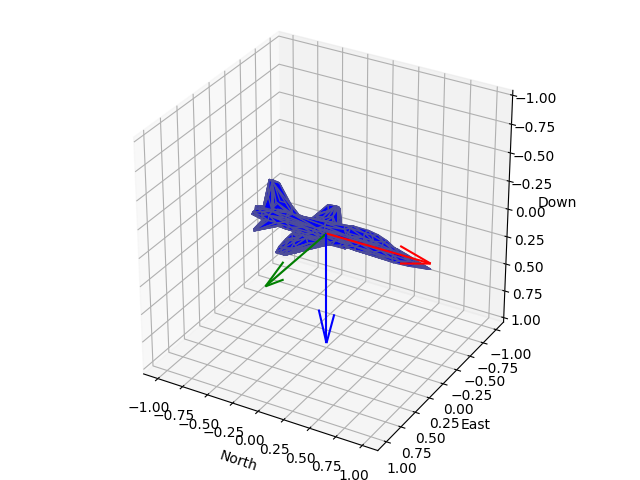

Widget Javascript not detected.  It may not be installed or enabled properly.


In [4]:
viz = Visualize()
viz.show()

In [5]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

### Kinematics
We will discuss the derivation of the quaternion kinematics as described by Shuster in 'A Survey of Attitude Representations'.

The kinematics can be shown as



\begin{align}
\label{eq:derivative_first}
q(t+\Delta t) &= \delta q(t)\otimes q(t) \\
&=\{\delta q(t)\}_Lq(t)
\end{align}


where $\delta q(t)$ describes a small rotation and $\{q\}_L$ is the matrix form of the quaternion. 

\begin{align}
\{q\}_L &= 
\begin{bmatrix}
 w & z &-y &x \\
-z & w & x &y \\
 y &-x & w &z \\
-x &-y &-z &w
\end{bmatrix}
\end{align}

Using Taylor Series expansion, $\delta q(t)$ can be expressed as

\begin{align}
\delta q(t) &= \begin{bmatrix} \Delta\xi(t)/2 \\ 1 \end{bmatrix} + O(|\Delta\xi(t)|^2)
\end{align}

where $O(|\Delta\xi(t)|^2)$ represent the higher order terms. The above expression can be expressed in matrix form

\begin{align}
\{\delta q(t)\}_L &= I_{4x4} + \frac{1}{2}\Omega_L(\Delta\xi(t)) + O(|\Delta\xi(t)|^2)
\end{align}

where 

\begin{align}
\Omega_L(v) &= 
\begin{bmatrix}
0 &v_3 &-v_2 &v_1 \\
-v_3 &0 &v_1 &v_2 \\
v_2 &-v_1 &0 &v_3 \\
-v_1 &-v_2 &-v_3 &0
\end{bmatrix}
\end{align}

Assuming that $\delta q(t)$ is very small, we can ignore the higher order terms, and equation $\ref{eq:derivative_first}$ can be expressed as.

\begin{align}
\label{eq:derivative_twelve}
q(t+\Delta t) &= \delta q(t)\otimes q(t) \\
q(t+\Delta t) &= (I_{4x4} + \frac{1}{2}\Omega_L(\Delta\xi(t))) q(t) \\
q(t+\Delta t) &= I_{4x4} q(t) + \frac{1}{2}\Omega_L(\Delta\xi(t)) q(t) \\
q(t+\Delta t) - I_{4x4} q(t) &= \frac{1}{2}\Omega_L(\Delta\xi(t)) q(t) \\
\frac{1}{\Delta t}(q(t+\Delta t) - I_{4x4} q(t)) &= \frac{1}{\Delta t}(\frac{1}{2}\Omega_L(\Delta\xi(t))q(t)) \\
\frac{d}{dt}q(t) &= \frac{1}{2}\Omega_L(\omega)q(1) = \frac{1}{2}w\otimes q(t)
\end{align}

Equation $\ref{eq:derivative_twelve}$ can also be written as 

\begin{align}
\frac{d}{dt}q(t) &= \frac{1}{2}\Xi(q)w
\end{align}

where

\begin{align}
\Xi(q) &= \begin{bmatrix}
w &-z &y \\
z &w &-x \\
-y &x &w \\
-x &-y &-z
\end{bmatrix}
\end{align}

The derivative method is defined below

In [6]:
class Quaternion(Quaternion):

    # Returns the derivative of the quaternion
    def get_derivative(self,w,Ts):

        mat = np.matrix([[ self._w, -self._z,  self._y],
                         [ self._z,  self._w, -self._x],
                         [-self._y,  self._x,  self._w],
                         [-self._x, -self._y, -self._z]])

        n = 0.5*mat*w*Ts
        # print(mat)
        # print(w)
        # print(n)
        return Quaternion(np.float(n[3]),np.float(n[0]),np.float(n[1]),np.float(n[2]))

## Naive Integration Methods

This sections cover the same integration methods that are discussed in [Solving Differential Equations](/notebooks/Unit-1-SO2/1.3-Solving-Differential-Equations.ipynb#Naive-Integration-Methods). These naive methods are used to demonstrate that they can cause the quaternion to move off the manifold which induces large errors. The naive integration methods that we will discuss are first order Euler's Method and Runge-Kutta 4(RK4) method.

## Euler's Method

The Euler method can be defined as 

\begin{align}
q(n+1) = q(n) + \Delta t \frac{d}{dt}q(n)
\end{align}

Notice that the addition operator is not part of the quaternion lie group. This will force $q(n+1)$ to leave the group. The error caused by this decreases as $\Delta t \rightarrow 0$ since as it approaches $0$, the part added to it approaches $0$.

It is possible to force $q(n+1)$ back onto the group by normalizing it; however, that does not remove the error in estimation. 

The method below performs Euler's method.

|q| final:  176218765.7752414


<IPython.core.display.Javascript object>


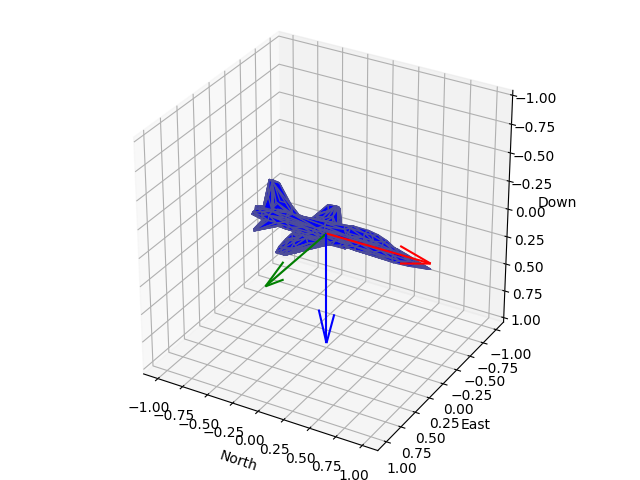

Widget Javascript not detected.  It may not be installed or enabled properly.


In [7]:
class Quaternion(Quaternion):

    def euler_integration(self, w, Ts=0.01, normalize=False):

        # Store trajectory
        trajectory = [Quaternion()]

        # Perform Euler integration for every gyro sample
        for i in range(w.shape[1]):
            self.equal(self+self.get_derivative(w[:,i].reshape(3,1),Ts))
            
            if normalize:
                self.normalize()
            # self.p()
            trajectory.append(self.copy())

        return trajectory


# Create Quaternion object
q = Quaternion()

# Generate gyro samples and create trajectory
samples = generate_gyro_samples(w0=np.array([[50],[50],[0]]), Ts=0.01, secs=5, alpha=0.1, sigma=0.25)
trajectory = q.euler_integration(samples['w'],samples['Ts'])
print("|q| final: ", trajectory[-1].magnitude())

# Convert quaternions to rotation matrices
for i in range(len(trajectory)):
    trajectory[i] = trajectory[i].q_to_r()

    
# Visualize the rotations
viz = Visualize(trajectory,samples['Ts'],samples['secs'])
viz.show()

By the object scaling, you can see that the quaternion has left the manifold. Note the final value of the magnitude of $q$.

### Runge-Kutta 4 (RK4)

The Runge-Kutta method can be used to approximate the derivative of a curvy function better than Euler's Method. For more information see [Runge-Kutta Methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) 

The implementation of this method is shown below.

|q| final:  0.9997320179969084


<IPython.core.display.Javascript object>


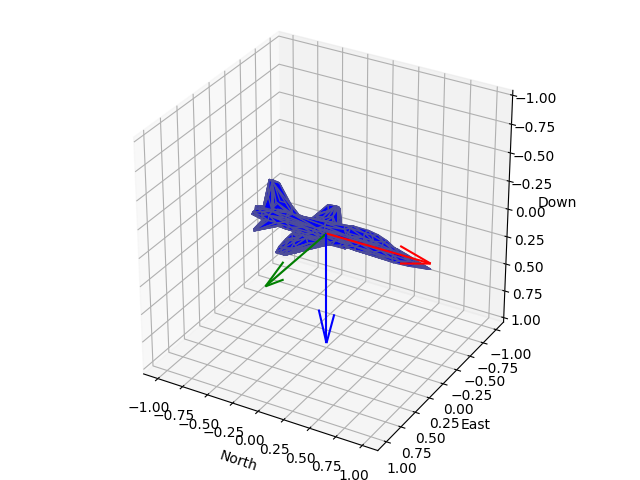

Widget Javascript not detected.  It may not be installed or enabled properly.


In [8]:
class Quaternion(Quaternion):

    def rk4_integration(self,w,Ts=0.01, normalize = False):
                # Store trajectory
        trajectory = [Quaternion()]

        f = lambda i,t,q: q.get_derivative(w[:,i].reshape(3,1),1)

        # Perform Euler integration for every gyro sample
        for i in range(w.shape[1]):

            t = i*Ts
            k1 = f(i,t,self)
            # k1.p()
            k2 = f(i, t+Ts/2, self + k1*(Ts/2))
            k3 = f(i, t+Ts/2, self + k2*(Ts/2))
            k4 = f(i, t+Ts,   self + k3*Ts)
            self += (k1+k2*2+k3*2+k4)*(Ts/6)
            
            if normalize:
                self.normalize()
            # self.p()
            trajectory.append(self.copy())

        return trajectory
    
# Create Quaternion object
q = Quaternion()

# Generate gyro samples and create trajectory
samples = generate_gyro_samples(w0=np.array([[0],[0],[50]]), Ts=0.01, secs=5, alpha=0.1, sigma=0.25)
trajectory = q.rk4_integration(samples['w'],samples['Ts'])
print("|q| final: ", trajectory[-1].magnitude())

# Convert quaternions to rotation matrices
for i in range(len(trajectory)):
    trajectory[i] = trajectory[i].q_to_r()

    
# Visualize the rotations
viz = Visualize(trajectory,samples['Ts'],samples['secs'])
viz.show()

Notice that RK4 does a lot better at keeping the quaternion on the manifold, but it still breaks the constraint $|q|=1$ within just 5 seconds. 

## Integrating on the Manifold

These classical numerical techniques are a great first approach, but they are prone to increassing error with time. Instead, the integration can occur directly on the manifold to ensure that it stays on it. 

Using the kinematics above

\begin{equation}
\dot{q} = f(q) = \frac{1}{2}q\otimes w
\end{equation}

is of the form

\begin{equation}
f(q) + p(t)q(t) = 0
\end{equation}

with $p(t) = -\frac{1}{2}w(t)$, we can use the integrating factor $\exp{(-\int_{t_0}^tw(\tau)d\tau)}$ to find a solution that satisfies the differential equation. The quaternion exponential map is defined as

\begin{equation}
e^{\theta n} = \cos{\theta} + \sin{\theta}n
\end{equation}

The kinematic equation can then be written as
\begin{equation}
(\dot{q}-\frac{1}{2}q\otimes w(t))\otimes e^{(-\int_{t_0}^t \frac{1}{2}w(\tau)d\tau)}=0
\end{equation}

Using the product rule, this becomes

\begin{equation}
\frac{d}{dt} \left[q \otimes e^{(-\int_{t_0}^t \frac{1}{2}w(\tau)d\tau)} \right] = 0
\end{equation}

Taking the integral of both sides 

\begin{equation}
\int^t_{t_0} \frac{d}{dt} \left[q \otimes e^{(-\int_{t_0}^t \frac{1}{2}w(\tau)d\tau)} \right] = 0
\end{equation}

for which we can use the Fundamental Theorem of Calculus 

\begin{align}
 q(t)\otimes e^{(-\int_{t_0}^t \frac{1}{2}w(\tau)d\tau)} &= q(t_0) \\
 q(t) &= q(t_0)\otimes e^{(\int_{t_0}^t \frac{1}{2}w(\tau)d\tau)}
\end{align}

### Digital Implementation

See [Digital Implementation:Zero-Order Hold](/notebooks/Unit-1-SO2/1.3-Solving-Differential-Equations.ipynb#Digital-Implementation:-Zero-Order-Hold) for a discussion about this implementation. In essence, we can discretize the analytic solution to be 

\begin{equation}
q(t) = q(t_0)\otimes e^{\frac{1}{2}w[n]T_s}
\end{equation}

|q| final:  1.0000000000000002


<IPython.core.display.Javascript object>


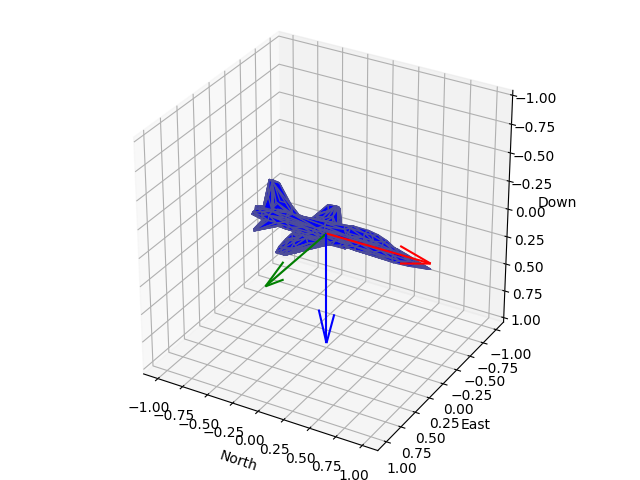

Widget Javascript not detected.  It may not be installed or enabled properly.


In [9]:
class Quaternion(Quaternion):

    def lie_integration(self,w,Ts):

        # Store trajectory
        trajectory = [Quaternion()]

        # Perform Euler integration for every gyro sample
        for i in range(w.shape[1]):

            q_dt = Quaternion.from_algebra(w[:,i].reshape(3,1)*Ts)
            self.equal(q_dt*self)
       
            trajectory.append(self.copy())

        return trajectory
    
# Create Quaternion object
q = Quaternion()

# Generate gyro samples and create trajectory
samples = generate_gyro_samples(w0=np.array([[10],[10],[0]]), Ts=0.01, secs=5, alpha=0.1, sigma=0.25)
trajectory = q.lie_integration(samples['w'],samples['Ts'])
print("|q| final: ", trajectory[-1].magnitude())

# Convert quaternions to rotation matrices
for i in range(len(trajectory)):
    trajectory[i] = trajectory[i].q_to_r()

    
# Visualize the rotations
viz = Visualize(trajectory,samples['Ts'],samples['secs'])
viz.show()